
12CO 1-0 Fit:
 - Peak Flux (a): 0.608 Jy/beam
 - Observed Frequency (f0): 1.153e+11 Hz
 - Line Width (sigma): 7.643e+06 Hz
 - Doppler Velocity: 38.93 km/s
 - Brightness Temperature: 0.56 K
 - Integrated Brightness Temp (∫T_B dv): -29.02 K km/s
 - Column Density: -5.78e+25 m^-2
 - Molecular Mass: -0.005 solar masses
 - Estimated Mass Loss Rate: -5.881e-05 solar masses per year


<ipython-input-6-52b386965c08>:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated_Tb_dv = np.trapz(T_brightness_arr, v_arr)


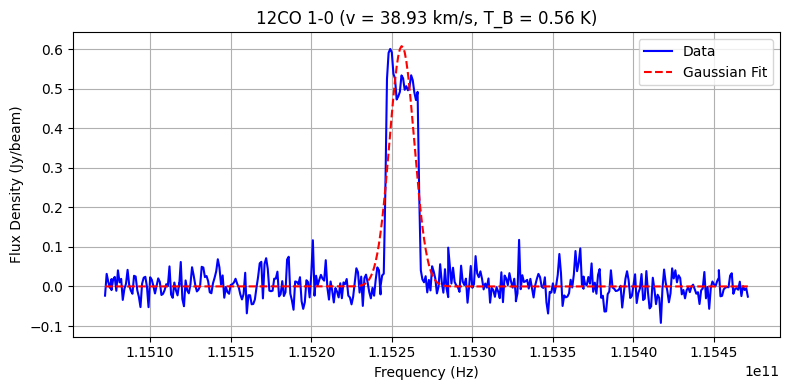


12CO 2-1 Fit:
 - Peak Flux (a): 1.663 Jy/beam
 - Observed Frequency (f0): 2.305e+11 Hz
 - Line Width (sigma): 1.426e+07 Hz
 - Doppler Velocity: 38.52 km/s
 - Brightness Temperature: 0.38 K
 - Integrated Brightness Temp (∫T_B dv): -16.98 K km/s
 - Column Density: -9.45e+24 m^-2
 - Molecular Mass: -0.001 solar masses
 - Estimated Mass Loss Rate: -9.517e-06 solar masses per year


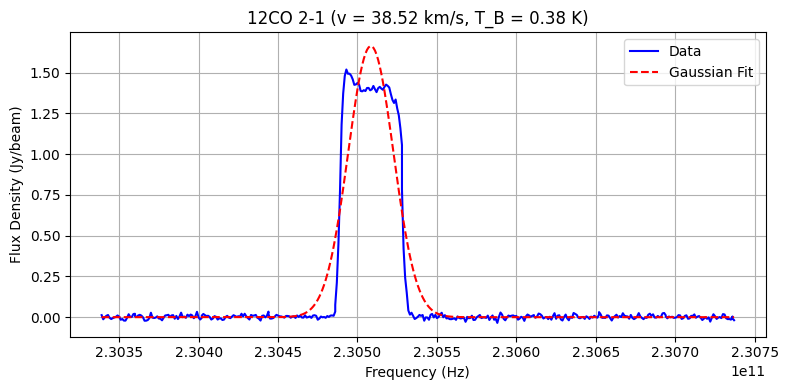


13CO 1-0 Fit:
 - Peak Flux (a): 0.013 Jy/beam
 - Observed Frequency (f0): 1.101e+11 Hz
 - Line Width (sigma): -3.159e+06 Hz
 - Doppler Velocity: 224.30 km/s
 - Brightness Temperature: 0.01 K
 - Integrated Brightness Temp (∫T_B dv): -0.30 K km/s
 - Column Density: -6.50e+23 m^-2
 - Molecular Mass: -0.000 solar masses
 - Estimated Mass Loss Rate: -3.810e-06 solar masses per year


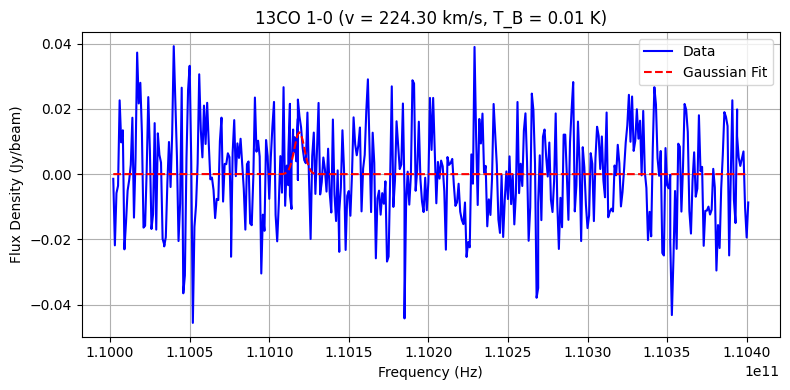


13CO 2-1 Fit:
 - Peak Flux (a): 0.023 Jy/beam
 - Observed Frequency (f0): 2.204e+11 Hz
 - Line Width (sigma): 1.353e+07 Hz
 - Doppler Velocity: 33.64 km/s
 - Brightness Temperature: 0.01 K
 - Integrated Brightness Temp (∫T_B dv): -0.10 K km/s
 - Column Density: -6.30e+22 m^-2
 - Molecular Mass: -0.000 solar masses
 - Estimated Mass Loss Rate: -5.541e-08 solar masses per year


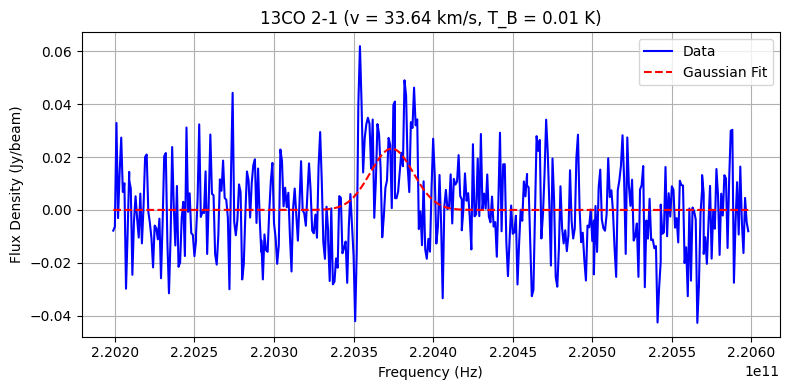

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the spectrum data
filename = 'spectrum.txt'
data = np.loadtxt(filename)
frequency = data[:, 0]  # in Hz
flux_density = data[:, 1]  # in Jy/beam

# Gaussian model function
def gaussian(f, a, f0, sigma):
    return a * np.exp(- (f - f0)**2 / (2 * sigma**2))

# Fit Gaussian around a given frequency
def fit_line_near(frequency, flux_density, rest_freq, window=2e8):
    mask = (frequency > rest_freq - window) & (frequency < rest_freq + window)
    f_slice = frequency[mask]
    flux_slice = flux_density[mask]

    if len(f_slice) < 5:
        print(f"Not enough data points around {rest_freq:.2e} Hz")
        return None

    a_guess = np.max(flux_slice)
    f0_guess = f_slice[np.argmax(flux_slice)]
    sigma_guess = (f_slice[-1] - f_slice[0]) / 10
    p0 = [a_guess, f0_guess, sigma_guess]

    try:
        popt, _ = curve_fit(gaussian, f_slice, flux_slice, p0=p0)
        return popt, f_slice, flux_slice
    except RuntimeError:
        print(f"Fit failed near {rest_freq:.2e} Hz")
        return None

# Constants
c = 3e8  # speed of light in m/s
k = 1.38e-23  # Boltzmann constant in J/K

# Beam size (FWHM) in arcseconds — replace with your actual value!
beam_fwhm_arcsec = 10
beam_fwhm_rad = beam_fwhm_arcsec * (np.pi / (180 * 3600))  # convert to radians
omega_beam = 1.133 * beam_fwhm_rad**2  # beam solid angle in steradians

# Rest frequencies of CO lines
rest_freqs = {
    "12CO 1-0": 115.27120e9,
    "12CO 2-1": 230.53800e9,
    "13CO 1-0": 110.20135e9,
    "13CO 2-1": 220.39868e9
}

for label, f_rest in rest_freqs.items():
    result = fit_line_near(frequency, flux_density, f_rest)
    if result:
        popt, f_slice, flux_slice = result
        peak_flux_jy = popt[0]  # in Jy/beam
        f_obs = popt[1]  # observed frequency in Hz
        sigma = popt[2]

        # Calculate Doppler velocity
        v_lsr = c * (f_rest - f_obs) / f_rest
        v_lsr_kms = v_lsr / 1000

        # Convert flux density peak to brightness temperature
        wavelength = c / f_obs  # in meters
        S_wm2hz = peak_flux_jy * 1e-26  # Jy to W/m²/Hz
        T_brightness = (S_wm2hz * wavelength**2) / (2 * k * omega_beam)  # in K

        print(f"\n{label} Fit:")
        print(f" - Peak Flux (a): {peak_flux_jy:.3f} Jy/beam")
        print(f" - Observed Frequency (f0): {f_obs:.3e} Hz")
        print(f" - Line Width (sigma): {sigma:.3e} Hz")
        print(f" - Doppler Velocity: {v_lsr_kms:.2f} km/s")
        print(f" - Brightness Temperature: {T_brightness:.2f} K")

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(f_slice, flux_slice, label='Data', color='blue')
        plt.plot(f_slice, gaussian(f_slice, *popt), '--', label='Gaussian Fit', color='red')
        plt.title(f"{label} (v = {v_lsr_kms:.2f} km/s, T_B = {T_brightness:.2f} K)")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Flux Density (Jy/beam)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


                # --- Additional calculations ---

        # Convert full flux density slice to brightness temperature array
        wavelength_arr = c / f_slice  # meters
        S_wm2hz_arr = flux_slice * 1e-26  # Jy to W/m^2/Hz
        T_brightness_arr = (S_wm2hz_arr * wavelength_arr**2) / (2 * k * omega_beam)  # K

        # Convert frequency array to velocity array (km/s)
        v_arr = c * (f_rest - f_slice) / f_rest / 1000  # km/s

        # Integrate brightness temperature over velocity to get line intensity (K km/s)
        integrated_Tb_dv = np.trapz(T_brightness_arr, v_arr)

        print(f" - Integrated Brightness Temp (∫T_B dv): {integrated_Tb_dv:.2f} K km/s")

        # Simple column density estimate for 12CO (optically thin approx)
        # Constants and parameters (replace with your values as needed)
        mu = 0.112 * 3.33564e-30  # dipole moment in C·m (0.112 Debye for CO)
        S = 1  # line strength (for J=1-0)
        g_u = 3  # upper state degeneracy
        E_u = 5.5  # upper state energy in K (for J=1)
        T_ex = 20  # assumed excitation temperature in K
        T_bg = 2.73  # cosmic background temperature in K

        def J_func(T, nu):
            h = 6.626e-34
            k_B = 1.38e-23
            return (h * nu / k_B) / (np.exp(h * nu / (k_B * T)) - 1)

        Q = 2 * T_ex / (6.626e-34 * f_rest / k)  # approximate partition function
        J_ex = J_func(T_ex, f_rest)
        J_bg = J_func(T_bg, f_rest)

        # Column density (m^-2), simplified formula:
        N = (3 * k) / (8 * np.pi**3 * f_rest * mu**2 * S) * (Q / g_u) * np.exp(E_u / T_ex) * integrated_Tb_dv / (J_ex - J_bg)

        # Assume source size and distance for mass calculation:
        distance_pc = 150  # parsecs
        source_size_arcsec = 10  # angular diameter in arcsec
        source_size_rad = source_size_arcsec * (np.pi / (180 * 3600))

        # Physical radius in meters
        R = distance_pc * 3.086e16 * source_size_rad / 2
        A = np.pi * R**2  # physical area in m²

        # Molecular mass calculation (assuming mean molecular weight 2.8)
        m_H = 1.67e-27  # hydrogen atom mass in kg
        mu_g = 2.8  # mean molecular weight
        mass_kg = mu_g * m_H * N * A
        mass_solar = mass_kg / 1.989e30

        print(f" - Column Density: {N:.2e} m^-2")
        print(f" - Molecular Mass: {mass_solar:.3f} solar masses")

        # Mass-loss rate estimate (assuming expansion velocity = Doppler velocity magnitude)
        v_exp_m_s = abs(v_lsr)  # m/s
        mass_loss_rate_kg_s = mass_kg * v_exp_m_s / R
        mass_loss_rate_msun_per_year = mass_loss_rate_kg_s / 1.989e30 * 3.154e7

        print(f" - Estimated Mass Loss Rate: {mass_loss_rate_msun_per_year:.3e} solar masses per year")






In [2]:
from google.colab import files
uploaded = files.upload()


Saving spectrum.txt to spectrum.txt
